# PPG Field Study Dataset

## Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as ti
import seaborn as sns
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.utils.fixes import loguniform

In [16]:
srBVP = 64 #sample rate of the BVP signal
srACC = 32 #sample rate of the accelerometere signal
srECG = 700 #sample rate of the ECC signal
srActivity = 4 #sample rate of the activity
windowSize = 8
shift = 2

## Loading the dataset

In [17]:
dics = []
for i in range(1,16):
    dics.append(pd.read_pickle(f'PPG_FieldStudy/S{i}/S{i}.pkl'))

In [18]:
for key in dics[0]:
    print(key)

rpeaks
signal
label
activity
questionnaire
subject


In [19]:
dics[0]

{'rpeaks': array([    240,    1174,    2128, ..., 6447292, 6447748, 6448224],
       dtype=int32),
 'signal': {'chest': {'ACC': array([[ 0.85640001, -0.06779999, -0.36559999],
          [ 0.8556    , -0.06900001, -0.3646    ],
          [ 0.852     , -0.07020003, -0.3642    ],
          ...,
          [ 0.88759995, -0.1038    , -0.27920002],
          [ 0.88619995, -0.10159999, -0.27819997],
          [ 0.88680005, -0.10140002, -0.27380002]]),
   'ECG': array([[0.01560974],
          [0.01812744],
          [0.01753235],
          ...,
          [0.21368408],
          [0.21556091],
          [0.21702576]]),
   'EMG': array([[-1.5],
          [-1.5],
          [-1.5],
          ...,
          [-1.5],
          [-1.5],
          [-1.5]]),
   'EDA': array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]),
   'Temp': array([[-273.15],
          [-273.15],
          [-273.15],
          ...,
          [-273.15],
          [-273.15],
    

## Subjects data

In [20]:
questionnaires = []
for i in range(0,len(dics)):
    questionnaires.append(dics[i]['questionnaire'])
questionnaires = pd.DataFrame.from_dict(questionnaires)
questionnaires

,WEIGHT,Gender,AGE,HEIGHT,SKIN,SPORT
0,78.0,m,34,182.0,3,6
1,80.0,m,28,189.0,3,5
2,60.0,m,25,170.0,3,5
3,57.0,m,25,168.0,4,5
4,70.0,f,21,180.0,3,4
5,70.0,f,37,176.0,3,1
6,58.0,f,21,168.0,3,2
7,70.0,m,43,179.0,3,5
8,60.0,f,28,167.0,4,5
9,56.0,f,55,164.0,4,5


In [21]:
questionnaires.index += 1
questionnaires

,WEIGHT,Gender,AGE,HEIGHT,SKIN,SPORT
1,78.0,m,34,182.0,3,6
2,80.0,m,28,189.0,3,5
3,60.0,m,25,170.0,3,5
4,57.0,m,25,168.0,4,5
5,70.0,f,21,180.0,3,4
6,70.0,f,37,176.0,3,1
7,58.0,f,21,168.0,3,2
8,70.0,m,43,179.0,3,5
9,60.0,f,28,167.0,4,5
10,56.0,f,55,164.0,4,5


In [22]:
questionnaires["BMI"]=questionnaires["WEIGHT"]/((questionnaires["HEIGHT"]/100)**2)
questionnaires

,WEIGHT,Gender,AGE,HEIGHT,SKIN,SPORT,BMI
1,78.0,m,34,182.0,3,6,23.547881
2,80.0,m,28,189.0,3,5,22.395790
3,60.0,m,25,170.0,3,5,20.761246
4,57.0,m,25,168.0,4,5,20.195578
5,70.0,f,21,180.0,3,4,21.604938
6,70.0,f,37,176.0,3,1,22.598140
7,58.0,f,21,168.0,3,2,20.549887
8,70.0,m,43,179.0,3,5,21.847009
9,60.0,f,28,167.0,4,5,21.513859
10,56.0,f,55,164.0,4,5,20.820940


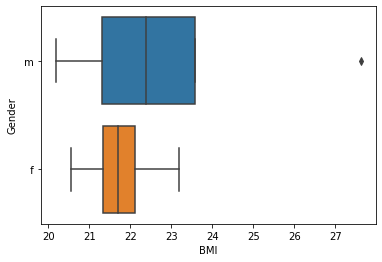

In [23]:
sns.boxplot(x='BMI', y='Gender', data=questionnaires)

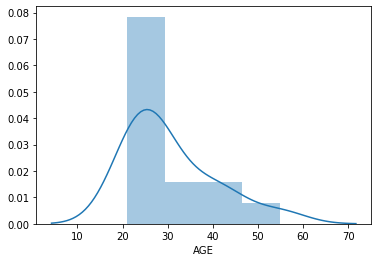

In [24]:
sns.distplot(questionnaires['AGE'])

## Target variable
### Input Signal

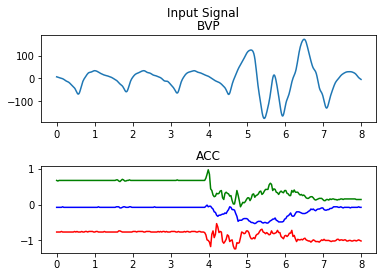

In [25]:
timescaleBVP = np.linspace(0,8,num=windowSize*srBVP)
timescaleACC = np.linspace(0,8,num=windowSize*srACC)
sample = 0
sample_BPV = dics[0]['signal']['wrist']['BVP'][sample:sample+windowSize*srBVP]
sample_ACC = dics[0]['signal']['wrist']['ACC'][sample:sample+windowSize*srACC]
sample_ACC = pd.DataFrame(sample_ACC, columns=['x','y','z'])
sample_ACC_x = sample_ACC.pop('x')
sample_ACC_y = sample_ACC.pop('y')
sample_ACC_z = sample_ACC.pop('z')
fig, axs = plt.subplots(2)
fig.suptitle('Input Signal')
axs[0].plot(timescaleBVP, sample_BPV)
axs[0].set_title('BVP')
axs[1].plot(timescaleACC, sample_ACC_x, color='red')
axs[1].plot(timescaleACC, sample_ACC_y, color='blue')
axs[1].plot(timescaleACC, sample_ACC_z, color='green')
axs[1].set_title('ACC')
plt.subplots_adjust(hspace = 0.5)

### Ground Truth

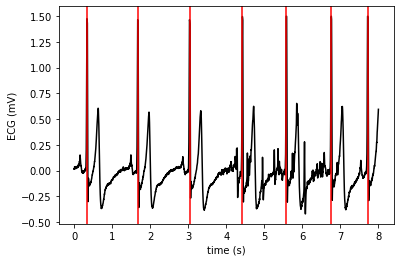

In [26]:
timescaleECG = np.linspace(0,8,num=windowSize*srECG)
sample_ECG = dics[0]['signal']['chest']['ECG'][sample:sample+windowSize*srECG]
sample_rpeaks = dics[0]['rpeaks'][sample:sample+7]
plt.plot(timescaleECG, sample_ECG, 'k')
plt.xlabel('time (s)')
plt.ylabel('ECG (mV)')
for line in sample_rpeaks:
    plt.axvline(x=line/700, color='red')
plt.show()

## Regression

The goal here is to predict the pulse of the subject from the BVP value

### Preparing the dataset

In [27]:
print(f"number of BVP values : {len(dics[0]['signal']['wrist']['BVP'])}")
print(f"nuber of labels : {len(dics[0]['label'])}")

number of BVP values : 589568
nuber of labels : 4603


In [28]:
y = dics[0]['label']
BVP = dics[0]['signal']['wrist']['BVP']
X = []
for i in range(0, len(BVP)-(windowSize*srBVP) + 1, shift*srBVP):
    X.append(BVP[i: i + windowSize*srBVP])
print(len(X))

4603


In [29]:
X = np.reshape(X, (len(X), len(X[0]))) #Getting rid of all the sub arrays

In [30]:
X[0]

array([   7.28,    6.33,    5.46,    4.6 ,    3.74,    2.86,    2.03,
          1.27,    0.57,   -0.2 ,   -1.17,   -2.48,   -4.14,   -6.07,
         -8.03,   -9.84,  -11.36,  -12.61,  -13.73,  -14.94,  -16.46,
        -18.4 ,  -20.81,  -23.6 ,  -26.58,  -29.54,  -32.28,  -34.73,
        -37.02,  -39.43,  -42.4 ,  -46.31,  -51.27,  -56.96,  -62.6 ,
        -67.1 ,  -69.37,  -68.58,  -64.52,  -57.56,  -48.59,  -38.71,
        -29.01,  -20.31,  -13.01,   -7.13,   -2.37,    1.74,    5.65,
          9.62,   13.68,   17.61,   21.05,   23.75,   25.58,   26.66,
         27.28,   27.78,   28.46,   29.46,   30.73,   32.09,   33.29,
         34.08,   34.34,   34.07,   33.38,   32.4 ,   31.22,   29.88,
         28.37,   26.75,   25.09,   23.5 ,   22.05,   20.72,   19.47,
         18.25,   17.07,   15.94,   14.96,   14.14,   13.45,   12.83,
         12.18,   11.43,   10.59,    9.68,    8.75,    7.83,    6.89,
          5.89,    4.75,    3.41,    1.87,    0.2 ,   -1.47,   -3.04,
         -4.52,   -6

### Trying estimators

In [31]:
results = []

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Linea Model

In [33]:
regr = linear_model.Ridge(alpha=.5)
t0 = ti.time()
regr.fit(X_train, y_train)
t1 = ti.time()
y_pred = regr.predict(X_test)
results.append(['linear_model',r2_score(y_test, y_pred),t1-t0])
results[-1]

['linear_model', -0.3697242059164969, 0.03216695785522461]

#### Support vector machine
with various kernels

In [34]:
clf = svm.SVR(kernel='rbf', cache_size=2000)
t0 = ti.time()
clf.fit(X_train, y_train)
t1 = ti.time()
y_pred = clf.predict(X_test)
results.append(['SVR_rbf',r2_score(y_test, y_pred),t1-t0])
results[-1]

['SVR_rbf', 0.16829401828942647, 9.03557300567627]

In [35]:
clf = svm.SVR(kernel='sigmoid', cache_size=2000)
t0 = ti.time()
clf.fit(X_train, y_train)
t1 = ti.time()
y_pred = clf.predict(X_test)
results.append(['SVR_sigmoid',r2_score(y_test, y_pred),t1-t0])
results[-1]

['SVR_sigmoid', -0.0843188343907757, 8.681973934173584]

In [36]:
clf = svm.SVR(kernel='poly', cache_size=2000)
t0 = ti.time()
clf.fit(X_train, y_train)
t1 = ti.time()
y_pred = clf.predict(X_test)
results.append(['SVR_poly',r2_score(y_test, y_pred),t1-t0])
results[-1]

['SVR_poly', -0.043800151054518066, 8.778284072875977]

#### Random Forest Regressor

In [37]:
regr = RandomForestRegressor()
t0 = ti.time()
regr.fit(X_train, y_train)
t1 = ti.time()
y_pred = regr.predict(X_test)
results.append(['RandomForestRegressor',r2_score(y_test, y_pred),t1-t0])
results[-1]

['RandomForestRegressor', 0.42252517060671135, 106.91499328613281]

#### Multi Layer Perceptron

In [38]:
regr = MLPRegressor()
t0 = ti.time()
regr.fit(X_train, y_train)
t1 = ti.time()
y_pred = regr.predict(X_test)
results.append(['MLPRegressor',r2_score(y_test, y_pred),t1-t0])
results[-1]

['MLPRegressor', -5.404802365465555, 1.6776671409606934]

### Analysis of the results

In [39]:
pdresults = pd.DataFrame(results, columns=['Regressor', 'R2-score', 'Trainning time'])
pdresults

,Regressor,R2-score,Trainning time
0,linear_model,-0.369724,0.032167
1,SVR_rbf,0.168294,9.035573
2,SVR_sigmoid,-0.084319,8.681974
3,SVR_poly,-0.043800,8.778284
4,RandomForestRegressor,0.422525,106.914993
5,MLPRegressor,-5.404802,1.677667


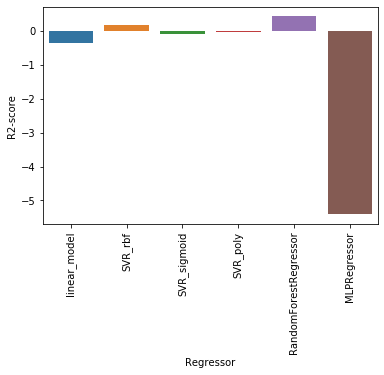

In [40]:
g = sns.barplot(x='Regressor', y='R2-score', data=pdresults)
g = g.set_xticklabels(g.get_xticklabels(),rotation=90)

The most promessing estimator is the Random forest Regression but since the SVR with the rbf kernel is much faster,
 
it's this regressor that we are gooing to use for the Grid Search

### Grid Search

In [41]:
parameters = {'C':[1, 10], 'tol':[1e-2, 1e-3, 1e-4]}
clf = svm.SVR(kernel='rbf')
clf = GridSearchCV(clf, parameters, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10], 'tol': [0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [42]:
clf.cv_results_

{'mean_fit_time': array([15.71923385, 15.76658349, 16.72748432, 17.3262722 , 15.88171883,
         9.38565326]),
 'std_fit_time': array([0.08520745, 0.10130187, 0.69007322, 0.09028857, 3.13413138,
        0.03413508]),
 'mean_score_time': array([3.85463629, 3.79950962, 4.22934361, 4.66495032, 4.30718584,
        1.92883677]),
 'std_score_time': array([0.07504722, 0.02394011, 0.37877979, 0.04837653, 1.18341866,
        0.00418595]),
 'param_C': masked_array(data=[1, 1, 1, 10, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_tol': masked_array(data=[0.01, 0.001, 0.0001, 0.01, 0.001, 0.0001],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'tol': 0.01},
  {'C': 1, 'tol': 0.001},
  {'C': 1, 'tol': 0.0001},
  {'C': 10, 'tol': 0.01},
  {'C': 10, 'tol': 0.001},
  {'C': 10, 'tol': 0.0001}],
 'split0_test_score': array([0.2088

### Trying out the best parameters given by the grid search

In [43]:
clf = svm.SVR(kernel='rbf', C= 10, tol=0.01, cache_size=2000)
t0 = ti.time()
clf.fit(X_train, y_train)
t1 = ti.time()
y_pred = clf.predict(X_test)
results.append(['SVR_GridSearch',r2_score(y_test, y_pred),t1-t0])
results[-1]

['SVR_GridSearch', 0.33239892374900937, 8.26863694190979]

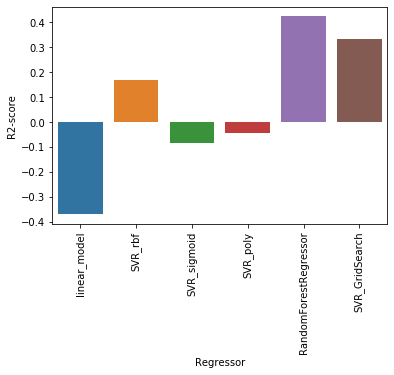

In [44]:
pdresults = pd.DataFrame(results, columns=['Regressor', 'R2-score', 'Trainning time'])
pdresults = pdresults.drop([5]) #Dropping the MLP result to see the improovement on the chart
g = sns.barplot(x='Regressor', y='R2-score', data=pdresults)
g = g.set_xticklabels(g.get_xticklabels(),rotation=90)

In [45]:
parameters = {'C':loguniform(10,500), 'tol':loguniform(0.7,10)}
clf = svm.SVR(kernel='rbf')
clf = RandomizedSearchCV(clf, parameters, n_jobs=-1, n_iter=500, verbose=2, cv=2)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.8min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=500, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x132ff9160>,
                                        'tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x132ff9400>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [46]:
clf.best_params_

{'C': 47.252381286500764, 'tol': 5.862314697467538}

In [47]:
clf = svm.SVR(kernel='rbf', C=55, tol=10, cache_size=2000)
t0 = ti.time()
clf.fit(X_train, y_train)
t1 = ti.time()
y_pred = clf.predict(X_test)
results.append(['SVR_RandomizedSearch',r2_score(y_test, y_pred),t1-t0])

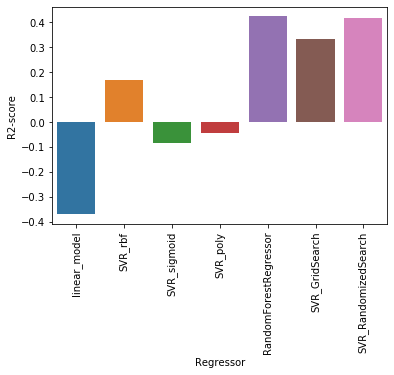

In [48]:
pdresults = pd.DataFrame(results, columns=['Regressor', 'R2-score', 'Trainning time'])
pdresults = pdresults.drop([5]) #Dropping the MLP result to see the improovement on the chart
g = sns.barplot(x='Regressor', y='R2-score', data=pdresults)
g = g.set_xticklabels(g.get_xticklabels(),rotation=90)

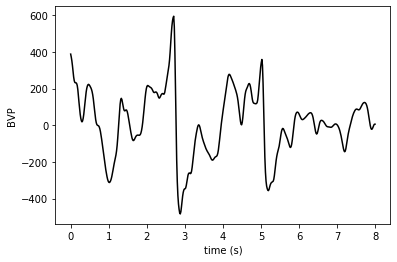

In [49]:
plt.plot(timescaleBVP, X_test[0], 'k')
plt.xlabel('time (s)')
plt.ylabel('BVP')
plt.show()

In [50]:
print(f'Ground truth: {y_test[0]}BPM')
print(f'Prediction: {clf.predict(np.array([X_test[0]]))[0]}BPM')

Ground truth: 89.08285285567997BPM
Prediction: 80.3777837994492BPM


In [51]:
mean_absolute_error(y_test, y_pred)

8.680086953105492

### Classification

Let's try to classify the activity of the subject

In [52]:
activity = dics[0]['activity']
yc = []
for i in range(0, len(activity)-(windowSize*srActivity) + 1, shift*srActivity):
    temp = activity[i: i + windowSize*srActivity]
    temp = np.reshape(temp,(len(temp))).astype(int)
    counts = np.bincount(temp)
    yc.append(np.argmax(counts))
len(yc)

4603

In [53]:
ACC = dics[0]['signal']['wrist']['ACC']
Xc = []
for i in range(0, len(ACC)-(windowSize*srACC) + 1, shift*srACC):
    Xc.append(ACC[i: i + windowSize*srACC])
len(Xc)

4603

In [54]:
Xc = np.delete(Xc, [1,2], 2)
Xc = np.reshape(Xc, (len(Xc), len(Xc[0])))
Xc

array([[-0.765625, -0.765625, -0.765625, ..., -0.984375, -1.      ,
        -1.015625],
       [-0.75    , -0.75    , -0.75    , ..., -0.96875 , -0.984375,
        -1.03125 ],
       [-1.046875, -1.171875, -0.828125, ..., -0.953125, -0.96875 ,
        -0.984375],
       ...,
       [-0.71875 , -0.59375 , -0.453125, ..., -0.4375  , -0.375   ,
        -0.296875],
       [-0.515625, -0.53125 , -0.515625, ..., -0.328125, -0.390625,
        -0.421875],
       [-0.515625, -0.484375, -0.375   , ..., -0.375   , -0.390625,
        -0.375   ]])

In [55]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2)

0.5504885993485342


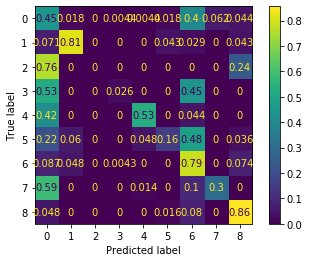

In [56]:
clf = svm.SVC()
clf.fit(Xc_train,yc_train)
yc_pred = clf.predict(Xc_test)
print(accuracy_score(yc_test, yc_pred))
plot_confusion_matrix(clf, Xc_test, yc_test, normalize='true')

0.6036916395222585


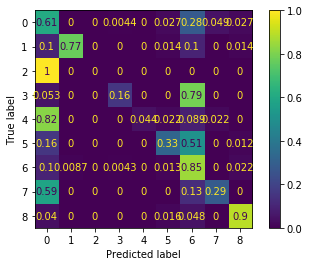

In [57]:
clf = RandomForestClassifier()
clf.fit(Xc_train,yc_train)
yc_pred = clf.predict(Xc_test)
print(accuracy_score(yc_test, yc_pred))
plot_confusion_matrix(clf, Xc_test, yc_test, normalize='true')

### Adding the heart rate as feature

In [61]:
HR = dics[0]['label']
ACC = dics[0]['signal']['wrist']['ACC']
Xc = []
j=0
for i in range(0, len(ACC)-(windowSize*srACC) + 1, shift*srACC):
    Xc.append(ACC[i: i + windowSize*srACC]+HR[j])
    j+=1
Xc = np.delete(Xc, [1,2], 2)
Xc = np.reshape(Xc, (len(Xc), len(Xc[0])))
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2)

0.4723127035830619


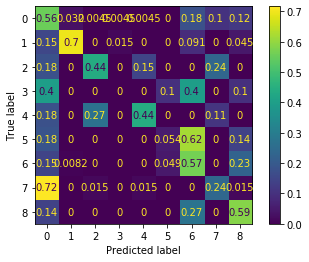

In [63]:
clf = RandomForestClassifier()
clf.fit(Xc_train,yc_train)
yc_pred = clf.predict(Xc_test)
print(accuracy_score(yc_test, yc_pred))
plot_confusion_matrix(clf, Xc_test, yc_test, normalize='true')

La classification n'est pas très efficace avec ACCx seul